# Model framework

**Example use (state: 6 June 2017)**

    from models import AverageModel
    avg = AverageModel()  # create model
    avg.predict()  # predict one time step into the future, return as pandas dataframe
    avg.predict_all()  # make predictions for all original time points, return as pandas dataframe
    avg.score()  # call predict_all() and return the mean squared error between the predictions and the actual polls

TODO:

- Implement Bayesian model as Model class
- calculate uncertainties for predictions
- maybe store model results in case we use Monte Carlo (make class which stores results and pickle this)

In [1]:
# TODO: Dirty hack to import from sibling dir. Put wahlrecht_polling_firms.py into the same folder as this file eventually.
import sys
import os
sys.path.append(os.path.abspath('../Backend'))
import wahlrecht_polling_firms

import numpy as np
import pandas as pd

import preprocessing

           AfD    CDU/CSU        FDP      GRÜNE      LINKE        SPD  \
0     9.000000  36.500000   9.000000   6.500000  10.500000  25.000000   
1     7.500000  38.666667   8.333333   7.833333   9.333333  24.333333   
2     7.333333  38.916667   8.833333   7.416667   9.333333  24.166667   
3     8.000000  38.375000   8.500000   7.125000   9.000000  24.125000   
4     8.000000  38.500000   8.500000   7.500000   9.000000  24.000000   
5     8.000000  38.083333   9.000000   7.166667   8.500000  24.833333   
6     7.800000  37.500000   8.900000   7.400000   8.400000  25.600000   
7     8.200000  37.600000   8.000000   7.000000   8.200000  26.400000   
8     8.750000  36.250000   7.000000   7.500000   8.750000  27.500000   
9     8.800000  35.600000   6.800000   7.100000   8.700000  28.500000   
10    8.333333  35.833333   6.083333   7.083333   8.916667  30.000000   
11    9.250000  35.250000   5.875000   6.250000   8.750000  30.375000   
12    9.500000  34.500000   6.125000   7.125000   8

/Users/d068730/Projects/University/Predictor/models/days_to_weeks.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  X = -(X - next_sunday).astype('timedelta64[D]').reshape(-1,1)
/Users/d068730/Projects/University/Predictor/models/preprocessing.py:83: RuntimeWarning: invalid value encountered in true_divide
  result[i,:] /= n


## Data & Helper functions

In [2]:
parties = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'LINKE', 'AfD', 'Sonstige']

In [7]:
data_dict = wahlrecht_polling_firms.get_tables()
# TODO: Some values are NaN --> how to handle these? Especially, the numbers have to add up to 1.
#data_dict = {key: df.fillna(0) for key, df in data_dict.items()}
data_dict.keys()

dict_keys(['allensbach', 'emnid', 'forsa', 'politbarometer', 'gms', 'dimap', 'insa'])

In [8]:
data = preprocessing.average(data_dict, 'simple')
data = pd.DataFrame.from_dict(data)
data

/Users/d068730/Projects/University/Predictor/models/days_to_weeks.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  X = -(X - next_sunday).astype('timedelta64[D]').reshape(-1,1)
/Users/d068730/Projects/University/Predictor/models/preprocessing.py:54: RuntimeWarning: invalid value encountered in true_divide
  result[i,:] /= n


,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,Sonstige,Befragte,Datum
0,9.000000,36.500000,9.000000,6.500000,10.500000,25.000000,3.500000,2044.0,2017-07-09
1,7.500000,38.666667,8.333333,7.833333,9.333333,24.333333,4.000000,4499.0,2017-07-02
2,7.500000,38.700000,8.500000,7.500000,9.500000,24.200000,4.100000,8606.0,2017-06-25
3,8.000000,38.375000,8.500000,7.125000,9.000000,24.125000,4.875000,7127.0,2017-06-18
4,8.000000,38.500000,8.500000,7.500000,9.000000,24.000000,4.500000,7439.0,2017-06-11
5,8.000000,37.900000,8.800000,7.000000,8.600000,25.200000,4.500000,8209.0,2017-06-04
6,7.750000,37.625000,8.875000,7.250000,8.500000,25.500000,4.500000,7704.0,2017-05-28
7,8.200000,37.600000,8.000000,7.000000,8.200000,26.400000,4.600000,9317.0,2017-05-21
8,8.750000,36.250000,7.000000,7.500000,8.750000,27.500000,4.250000,7408.0,2017-05-14
9,8.750000,35.500000,6.750000,7.125000,8.875000,28.375000,4.625000,7476.0,2017-05-07


In [9]:
pd.set_option('display.max_rows', len(data))
data

,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,Sonstige,Befragte,Datum
0,9.000000,36.500000,9.000000,6.500000,10.500000,25.000000,3.500000,2044.0,2017-07-09
1,7.500000,38.666667,8.333333,7.833333,9.333333,24.333333,4.000000,4499.0,2017-07-02
2,7.500000,38.700000,8.500000,7.500000,9.500000,24.200000,4.100000,8606.0,2017-06-25
3,8.000000,38.375000,8.500000,7.125000,9.000000,24.125000,4.875000,7127.0,2017-06-18
4,8.000000,38.500000,8.500000,7.500000,9.000000,24.000000,4.500000,7439.0,2017-06-11
5,8.000000,37.900000,8.800000,7.000000,8.600000,25.200000,4.500000,8209.0,2017-06-04
6,7.750000,37.625000,8.875000,7.250000,8.500000,25.500000,4.500000,7704.0,2017-05-28
7,8.200000,37.600000,8.000000,7.000000,8.200000,26.400000,4.600000,9317.0,2017-05-21
8,8.750000,36.250000,7.000000,7.500000,8.750000,27.500000,4.250000,7408.0,2017-05-14
9,8.750000,35.500000,6.750000,7.125000,8.875000,28.375000,4.625000,7476.0,2017-05-07


In [93]:
def _normalize_to_hundred(x, axis=None):
    """Normalize an array so that its sum is 1."""
    x = np.asarray(x)
    return 100 * x / np.sum(x, axis=axis)

np.sum(_normalize_to_hundred(np.linspace(0, 10)))

100.00000000000001

In [11]:
def _prediction_to_dataframe(prediction):
    """Wrap an array with the predictions into a dataframe containing the party names."""
    return pd.DataFrame(data=[prediction], columns=parties)

_prediction_to_dataframe(range(len(parties)))

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,0,1,2,3,4,5,6


In [12]:
def mse(poll_df, prediction_df):
    """Calculate the mean squared error between the polling results in `poll_df` and the predictions in `prediction_df`. Average over all parties."""
    mse = 0
    for party in parties:
        # TODO: NaN values are not properly handled here. Disregard them for the mse calculation. 
        true_results = poll_df[party]
        predicted_results = prediction_df[party][1:1+len(poll_df)]  # first point is prediction into the future, do not use it
        mse += np.mean((true_results - predicted_results)**2)
    return mse / len(parties)

## Models

In [13]:
class Model():
    
    def fit(self, df=data):
        """Optional fit step to call before predictions. Leave empty if the model does not support fitting."""
        return
    
    def predict(self, df=data):
        raise NotImplementedError()
    
    def predict_all(self, df=data):
        """Make a prediction for each time point in the data."""
        #print('Applying model to {} time points...'.format(len(data)))

        # First prediction, append the other ones below.
        prediction_df = self.predict(df)

        for i in range(1, len(df)):
            # Note: Appending the data frames takes up almost no time here, the bottleneck is the model.
            prediction_df = prediction_df.append(self.predict(df[i:]), ignore_index=True)
        
        return prediction_df
    
    # TODO: With the new averaging in preprocessing, scoring the model against different polling firms isn't that simple any more. Maybe make a function in preprocessing that converts the data of a single polling firm to the weekly format.
    def score(self, data=data, polling_firm=None):
        """Calculate a score for the model (lower is better). The score is the mean squared error between the model's predictions and the true results.
        If `polling_firm` is None (default), return a dict with the score for each polling firm. Otherwise, return only the score for that polling firm."""
        prediction_df = self.predict_all(data)
        return mse(data, prediction_df)
    
        #if polling_firm is None:
        #    return {polling_firm: mse(poll_df, prediction_df) for polling_firm, poll_df in data_dict.items()}
        #else: 
        #    return mse(data_dict[polling_firm], prediction_df)

In [97]:
class PolynomialModel(Model):
    """Fit a polynomial of degree `degree` through the last `n_last` polls and calculate one point into the future."""
    
    def __init__(self, n_last=5, degree=1):
        self.n_last = n_last
        self.degree = degree
        
    def predict(self, df=data):
        # TODO: Double-check that this works properly.
        prediction = []
        
        if self.n_last == None:  # use all rows
            num_rows = len(df)
        else:  # use just the n_last rows
            num_rows = self.n_last
            
        data_for_regression = df[parties].iloc[:num_rows].fillna(0)
        x_pred = data_for_regression.index.values[0] - 1
        
        # TODO: Use dropna here.
        # Drop rows that contain only NaN values.
        data_for_regression = data_for_regression[[not (row == 0).all() for _, row in data_for_regression.iterrows()]]
        
        x = data_for_regression.index.values
        
        for party in parties:
            y = data_for_regression[party]
            
            if len(x) > 0 and len(y) > 0:
                y_pred = np.poly1d(np.polyfit(x, y, self.degree))(x_pred)
            else:
                y_pred = np.nan
                
            prediction.append(y_pred)
            
        prediction = _normalize_to_hundred(prediction)
        
        prediction_df = pd.DataFrame(columns=parties, index=[0])
        for i, party in enumerate(parties):
            mean = prediction[i]
            # TODO: Calculate error via scipy function and insert min/mean/max in here.
            prediction_df[party][0] = [mean, mean, mean]
        return prediction_df
        
PolynomialModel(degree=2).predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[34.815, 34.815, 34.815]","[25.565, 25.565, 25.565]","[5.925, 5.925, 5.925]","[9.4, 9.4, 9.4]","[11.3, 11.3, 11.3]","[10.2, 10.2, 10.2]","[2.795, 2.795, 2.795]"


In [98]:
class LinearModel(PolynomialModel):
    """Fit a line through the last `n_last` polls and calculate one point into the future."""
    
    def __init__(self, n_last=5):
        PolynomialModel.__init__(self, n_last=n_last, degree=1)
        
LinearModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[37.0358333333, 37.0358333333, 37.0358333333]","[24.9941666667, 24.9941666667, 24.9941666667]","[6.90416666667, 6.90416666667, 6.90416666667]","[8.81666666667, 8.81666666667, 8.81666666667]","[10.4666666667, 10.4666666667, 10.4666666667]","[8.45, 8.45, 8.45]","[3.3325, 3.3325, 3.3325]"


In [89]:
class DecayModel(Model):
    """Average the last `n_last` polls (`None`, i.e. all by default), where polls further back are weighted less (exponential decay)."""
    
    def __init__(self, n_last=None, decay_factor=0.9):
        self.n_last = n_last
        self.decay_factor = decay_factor
    
    def fit(self):
        # TODO: Fit decay_factor to get best results.
        pass
        
    # TODO: Maybe generalize by letting AverageModel and DecayModel inherit from each other or common base class.
    def predict(self, df=data):
        prediction = np.zeros(len(parties))
        prediction_error = np.zeros(len(parties))
        
        if self.n_last == None:  # use all rows
            num_rows = len(df)
        else:  # use just the n_last rows
            num_rows = self.n_last
            
        # TODO: Take decaying average of uncertainties according to p * (1-p) / n.
            
        for i in range(min(num_rows, len(df))):  # do not use more rows than the dataframe has
            results = df[parties].iloc[i].fillna(0)
            if not (results == 0).all():  # ignore empty rows
                prediction += results * self.decay_factor**(i+1)
                
                # Calculate error according to formula from paper: sqrt(p * (1-p) / n)
                p = results / 100
                n = df['Befragte'].fillna(0).iloc[i]
                if n > 0:
                    errors = 100 * np.sqrt(p * (1 - p) / n)
                    prediction_error += errors * self.decay_factor**(i+1)
            
        prediction = _normalize_to_hundred(prediction)
        
        prediction_df = pd.DataFrame(index=[0], columns=parties)
        for i, party in enumerate(parties):
            mean = prediction[i]
            error = prediction_error[i]
            prediction_df[party][0] = [mean - error, mean, mean + error]
            
        return prediction_df
    
DecayModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[30.9161950478, 36.4200511925, 41.9239073371]","[21.3432261661, 26.3585814697, 31.3739367734]","[4.48870384046, 7.47825144854, 10.4677990566]","[4.50487754091, 7.53788948551, 10.5709014301]","[5.70953298714, 9.00330461215, 12.2970762372]","[5.59727182829, 8.83319258425, 12.0691133402]","[2.05319481922, 4.36872920732, 6.68426359542]"


In [90]:
class AverageModel(DecayModel):
    """Average the last `n_last` polls (5 by default)."""
    
    def __init__(self, n_last=5):
        DecayModel.__init__(self, n_last=n_last, decay_factor=1)
        
AverageModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[34.6921981595, 38.1483333333, 41.6044685071]","[21.2705279517, 24.3316666667, 27.3928053816]","[5.45177463736, 7.29166666667, 9.13155869598]","[6.56730543805, 8.56666666667, 10.5660278953]","[7.36804640899, 9.46666666667, 11.5652869243]","[6.05449627583, 8.0, 9.94550372417]","[2.78716821123, 4.195, 5.60283178877]"


In [92]:
class LatestModel(AverageModel):
    """Use the latest poll."""
    
    def __init__(self):
        AverageModel.__init__(self, n_last=1)
    
LatestModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[35.4351391774, 36.5, 37.5648608226]","[24.0422322921, 25.0, 25.9577677079]","[5.95471689968, 6.5, 7.04528310032]","[8.36700321367, 9.0, 9.63299678633]","[9.82194375309, 10.5, 11.1780562469]","[8.36700321367, 9.0, 9.63299678633]","[3.09350310453, 3.5, 3.90649689547]"


In [105]:
import GPflow

class GPModel(Model):
    """TODO. In contrast to the other models, GPModel always makes predictions for all time points. Therefore, `predict` just returns the latest data point from `predict_all`."""
    
    def __init__(self, k=GPflow.kernels.Matern32(1, variance=1, lengthscales=1.2)):
        self.kernel=k
        
    def predict(self, df=data):
        return self.predict_all(df).iloc[0]
    
    def predict_all(self, df=data):
        Y = df[parties]
        Y = Y.dropna(how='all').fillna(0)
        X = Y.index.values
        
        #X = pd.to_datetime(data.Datum)
        #X=-(X-dt.date.today()).astype('timedelta64[D]').reshape(-1,1)
        X = -X.reshape(-1,1).astype(float)
        
        #print(Y)

        m = GPflow.gpr.GPR(X, pd.DataFrame.as_matrix(Y), kern=self.kernel)
        m.optimize()
        
        x_pred = np.linspace(X[0,0],X[-1,0], 1000).reshape(-1,1)

        mean, var = m.predict_y(x_pred)
        # TODO: Integrate this into _normalize_to_hundred.
        prediction = 100 * mean / np.sum(mean, axis=1).reshape(-1, 1)
        
        prediction_df = pd.DataFrame(index=range(len(prediction)), columns=parties)
        for j in range(len(prediction)):
            for i, party in enumerate(parties):
                mean = prediction[j, i]
                prediction_df[party][j] = [mean, mean, mean]
        
        return prediction_df
    
GPModel().predict_all(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[37.6836176232, 37.6836176232, 37.6836176232]","[24.3966703632, 24.3966703632, 24.3966703632]","[7.10234292153, 7.10234292153, 7.10234292153]","[8.7654786756, 8.7654786756, 8.7654786756]","[10.0422258581, 10.0422258581, 10.0422258581]","[8.24210612206, 8.24210612206, 8.24210612206]","[3.76755843635, 3.76755843635, 3.76755843635]"
1,"[37.8141031352, 37.8141031352, 37.8141031352]","[24.358128357, 24.358128357, 24.358128357]","[7.15133418217, 7.15133418217, 7.15133418217]","[8.74234169729, 8.74234169729, 8.74234169729]","[9.91058009094, 9.91058009094, 9.91058009094]","[8.1649746043, 8.1649746043, 8.1649746043]","[3.8585379331, 3.8585379331, 3.8585379331]"
2,"[37.9398749559, 37.9398749559, 37.9398749559]","[24.3226611659, 24.3226611659, 24.3226611659]","[7.19750824767, 7.19750824767, 7.19750824767]","[8.72020397997, 8.72020397997, 8.72020397997]","[9.77880679099, 9.77880679099, 9.77880679099]","[8.09101564035, 8.09101564035, 8.09101564035]","[3.94992921921, 3.94992921921, 3.94992921921]"
3,"[38.0532534514, 38.0532534514, 38.0532534514]","[24.2942533005, 24.2942533005, 24.2942533005]","[7.2369790672, 7.2369790672, 7.2369790672]","[8.70055743966, 8.70055743966, 8.70055743966]","[9.64979600181, 9.64979600181, 9.64979600181]","[8.02513490161, 8.02513490161, 8.02513490161]","[4.04002583778, 4.04002583778, 4.04002583778]"
4,"[38.1486552526, 38.1486552526, 38.1486552526]","[24.2769724566, 24.2769724566, 24.2769724566]","[7.26779365594, 7.26779365594, 7.26779365594]","[8.68370993981, 8.68370993981, 8.68370993981]","[9.52524746754, 9.52524746754, 9.52524746754]","[7.97048962055, 7.97048962055, 7.97048962055]","[4.12713160698, 4.12713160698, 4.12713160698]"
5,"[38.2226371464, 38.2226371464, 38.2226371464]","[24.2749764057, 24.2749764057, 24.2749764057]","[7.28997688031, 7.28997688031, 7.28997688031]","[8.66875681944, 8.66875681944, 8.66875681944]","[9.40564483357, 9.40564483357, 9.40564483357]","[7.928449981, 7.928449981, 7.928449981]","[4.20955793367, 4.20955793367, 4.20955793367]"
6,"[38.272331677, 38.272331677, 38.272331677]","[24.2923570389, 24.2923570389, 24.2923570389]","[7.30385379783, 7.30385379783, 7.30385379783]","[8.6545659335, 8.6545659335, 8.6545659335]","[9.29152735651, 9.29152735651, 9.29152735651]","[7.89987008243, 7.89987008243, 7.89987008243]","[4.2854941139, 4.2854941139, 4.2854941139]"
7,"[38.2969614235, 38.2969614235, 38.2969614235]","[24.332884374, 24.332884374, 24.332884374]","[7.31067080567, 7.31067080567, 7.31067080567]","[8.63926102699, 8.63926102699, 8.63926102699]","[9.18387286102, 9.18387286102, 9.18387286102]","[7.88372029561, 7.88372029561, 7.88372029561]","[4.35262921321, 4.35262921321, 4.35262921321]"
8,"[38.2962989629, 38.2962989629, 38.2962989629]","[24.4002247499, 24.4002247499, 24.4002247499]","[7.31189333147, 7.31189333147, 7.31189333147]","[8.62075379696, 8.62075379696, 8.62075379696]","[9.08376763611, 9.08376763611, 9.08376763611]","[7.8784919493, 7.8784919493, 7.8784919493]","[4.40856957329, 4.40856957329, 4.40856957329]"
9,"[38.2703309455, 38.2703309455, 38.2703309455]","[24.4973227215, 24.4973227215, 24.4973227215]","[7.30841070308, 7.30841070308, 7.30841070308]","[8.59655782984, 8.59655782984, 8.59655782984]","[8.99191018216, 8.99191018216, 8.99191018216]","[7.88305229759, 7.88305229759, 7.88305229759]","[4.45241532032, 4.45241532032, 4.45241532032]"


# Quick and dirty evaluation

In [59]:
AverageModel().predict_all(data)

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,38.095000,24.705000,7.125000,8.660000,9.220000,8.000000,4.195000
1,38.220000,24.605000,7.275000,8.635000,8.920000,7.850000,4.495000
2,38.000000,25.045000,7.175000,8.535000,8.660000,7.990000,4.595000
3,37.575000,25.720000,7.250000,8.235000,8.610000,8.140000,4.470000
4,36.975000,26.595000,7.175000,7.885000,8.585000,8.290000,4.495000
5,36.555000,27.515000,7.195000,7.345000,8.645000,8.410000,4.335000
6,36.080000,28.490000,6.995000,6.745000,8.695000,8.710000,4.285000
7,35.460000,29.385000,7.020000,6.370000,8.680000,8.970000,4.115000
8,35.110000,30.210000,6.895000,6.045000,8.630000,8.970000,4.140000
9,34.660000,31.035000,6.870000,5.920000,8.480000,8.870000,4.165000


In [60]:
AverageModel().score(data)

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


0.7974966867674459

In [61]:
models = [AverageModel, LatestModel, DecayModel]

In [25]:
# Depreceated.

# MSE for all models.

# TODO: Maybe show a pandas table or a pcolor plot instead of the tabulate table here.
mse_df = pd.DataFrame(columns=data_dict.keys(), index=[model.__name__ for model in models])
for model in models:
    print('Running model: {}'.format(model.__name__))
    mse_dict = model().score(data_dict)
    mse_df.loc[model.__name__] = pd.Series(mse_dict)
    #result_table.append([model.__name__, *mses.values()])

print()
print('MSE between predicted results from model (vertical) and polls (horizontal):')

mse_df

Running model: AverageModel
Running model: WeightedAverageModel
Running model: LatestModel
Running model: WeightedLatestModel
Running model: DecayModel
Running model: WeightedDecayModel

MSE between predicted results from model (vertical) and polls (horizontal):


,allensbach,emnid,forsa,politbarometer,gms,dimap,insa
AverageModel,4.39424,1.9992,1.89508,5.13031,11.6376,3.95384,3.5941
WeightedAverageModel,6.7288,1.22622,1.26525,7.58613,15.1602,4.81996,2.67714
LatestModel,4.58096,1.76355,1.5239,5.12015,11.7845,3.97941,3.23137
WeightedLatestModel,7.05105,0.978359,0.872095,7.81436,15.4589,5.21948,2.31105
DecayModel,3.97555,2.53056,2.41619,4.70169,11.5139,3.79322,4.14285
WeightedDecayModel,5.99084,1.86884,1.88422,6.29939,14.4698,3.95591,3.32519


In [63]:
prediction_data_dict = {model.__name__: model().predict_all(data) for model in models}

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


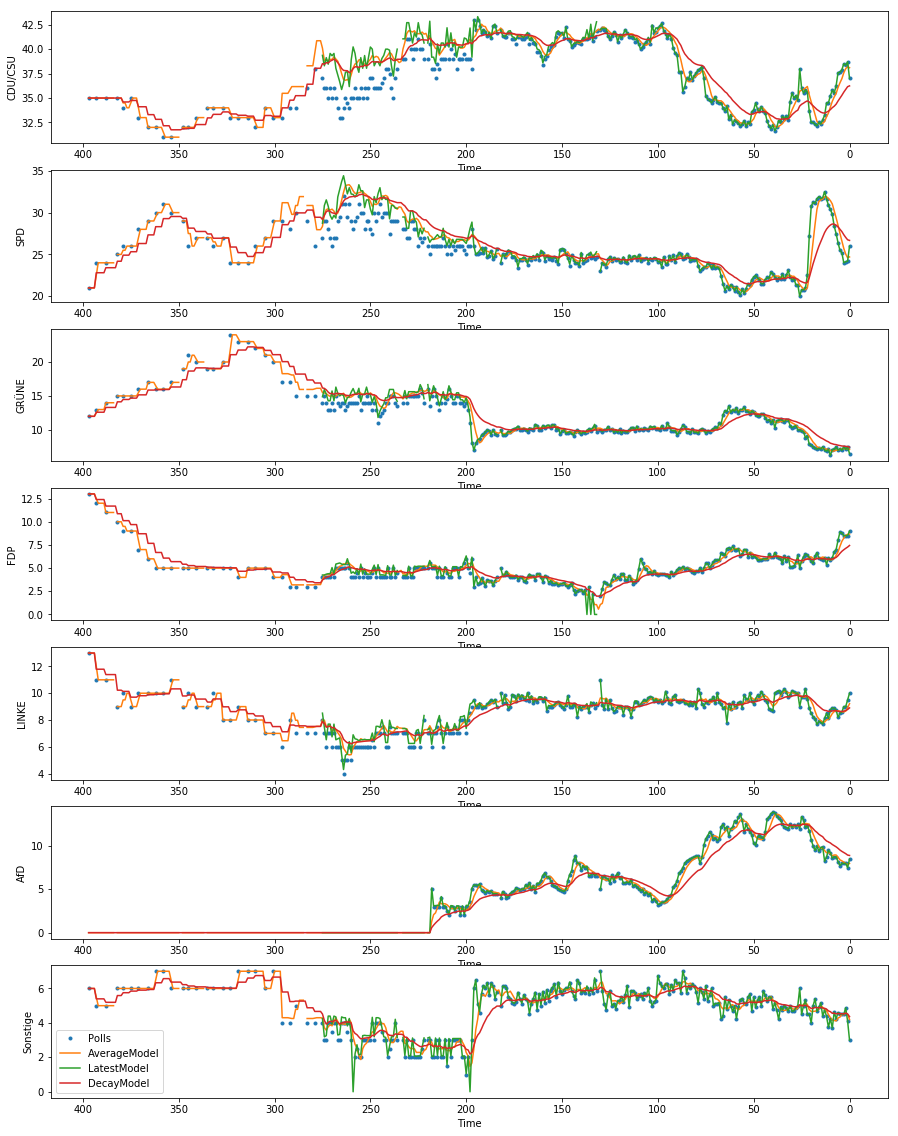

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(len(parties), figsize=(15, 20))

for ax, party in zip(axes, parties):
    plt.sca(ax)
    
    plt.plot(data[party], '.', label='Polls')

    for model, df in prediction_data_dict.items():
        plt.plot(df[party], label=model)
        
    #for polling_institute, df in data_dict.items():
    #    plt.plot(df[party], '--', label=polling_institute)

    #plt.legend()
    plt.gca().invert_xaxis()  # TODO: Time is inverted in data frames. Handle that somehow.
    plt.ylabel(party)
    plt.xlabel('Time')
    
plt.legend()